In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

In [14]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [15]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

all_dengues_mth = provinces_df.resample('M').size()
all_dengues_mth_df = pd.DataFrame(all_dengues_mth,columns=['cases'])
all_train_test_mth = split_data(all_dengues_mth_df)
all_dengues_train_mth, all_dengues_test_mth = all_train_test_mth[0], all_train_test_mth[1]

In [16]:
# all_dengues_train_mth

In [17]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(predictions)+start_week)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((13*2),15000,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$ARIMA (1, 1, 0) \times (0, 1, 0)$$

$$\hat{Y}_{t} - Y_{t - 1} = \mu + \phi\,(Y_{t-12} - Y_{t-13})$$

$$\hat{Y}_{t} = \mu + Y_{t-1} + \phi\,(Y_{t-12} - Y_{t-13})$$

$$\hat{Y}_{t} = \mu + Y_{t - 12} + (Y_{t-1} -\, Y_{t-13}) + \phi\,(Y_{t-1} - Y_{t-2})$$

If the ACF model shows autocorrelation and stationary, perhaps the problem can be fixed by adding one lag of the dependent variable to the prediction equation--i.e., by regressing the first difference of Y on itself lagged by one period.

This is a first-order autoregressive model with one order of nonseasonal differencing, one order of seasonale differencing, and a constant term

In [41]:
train_mth = all_dengues_train_mth
test_mth = all_dengues_test_mth
train_test_mth = all_dengues_mth_df.cases

def guess(w,y_cases): # should take in two w's
    y_12 = y_cases[1]
    y_13 = y_cases[0]
    y_1 = y_cases[12]
    y_2 = y_cases[11]
    s_diff = y_1 - y_13
    nons_diff = y_1 - y_2
    return w[0] + y_12 + s_diff + (w[1]*nons_diff)
#     return w[0] + y_1 + (w[1]*s_diff)

def cost(w):
    ret = 0
    for i in range(len(train_mth)-13):
        real_case = train_mth[i+13]
#         print train[i:i+13]
        predicted_case = guess(w,train_mth[i:i+13])
#         print predicted_case
        ret += (real_case-predicted_case)**2
#     print ret/float(len(train))
    return ret/float(len(train_mth))

In [42]:
arr = [30,0.]
w = minimize(cost,arr)

In [43]:
w

      fun: 2288407.4626620067
 hess_inv: array([[  5.75203801e-01,  -5.35714452e-06],
       [ -5.35714452e-06,   1.12791291e-07]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([ 25.24104435,   0.32017573])

In [44]:
prediction_ = []
for i in range(len(train_test_mth)-12):
    res = guess(w.x,train_test_mth[i:i+13])
    prediction_.append(res)
    
# prediction_


In [45]:
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data)+1, color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-10,30000,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,30000,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

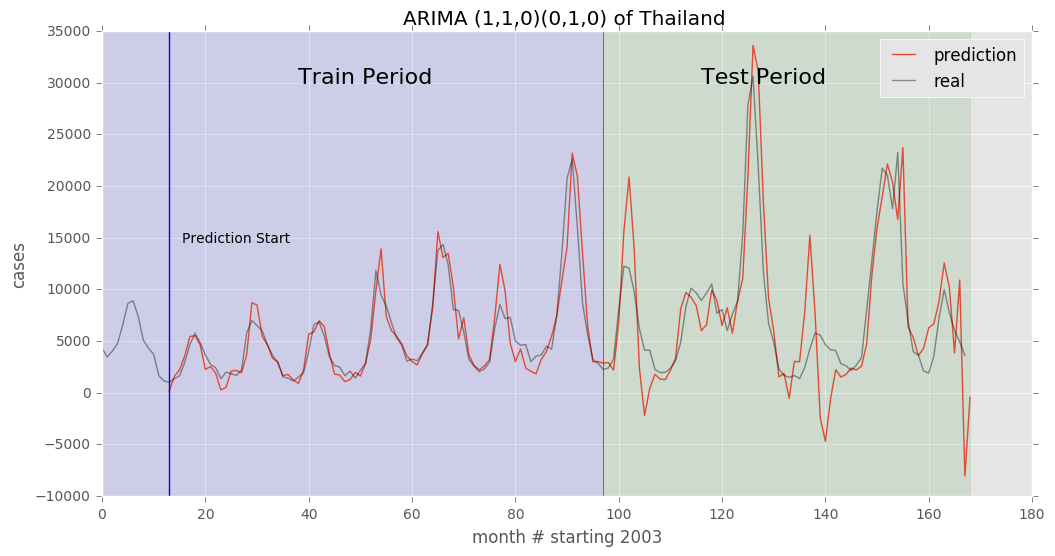

In [46]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(13,len(prediction_)+13)],prediction_,label='prediction')
plt.plot([i for i in range(len(train_test_mth))],train_test_mth,'-k',label='real',alpha=0.4)
plt.xlabel("month # starting 2003")
plt.ylabel("cases")
plt.title("ARIMA (1,1,0)(0,1,0) of Thailand ")
plt.axvline(13)
plt.text((13*2),15000,'Prediction Start',horizontalalignment='center',verticalalignment='center')
plt.legend()
seperate_train_test(train_test_mth,train_mth)

In [47]:
def plot_prediction(LAG,real,ws,province,nweek_to_predict=[1,2,4,12]):

    def n_week_ahead(array_x,weeks_ahead):

        cur_guess = 0
        arr = np.array(array_x)
        for i in range(weeks_ahead): 
            cur_guess = guess(ws,arr)
            arr = np.append(arr[1:],cur_guess)
        return cur_guess

    for i in nweek_to_predict:
        N = LAG + (i - 1)
        predictions = []
        for j in range(len(real)-(LAG-1)):
            initial_arr = real[j:j+LAG]
            predictions.append(n_week_ahead(initial_arr,i)) 
            
#         print len(real)
#         print len(predictions)
#         print i
    
        title = "%s's Dengue Prediction %d lags: %d month(s) ahead"%(province,LAG,i)
        make_line(LAG+(i-1),real,predictions,title,"# month starting 2003","cases")

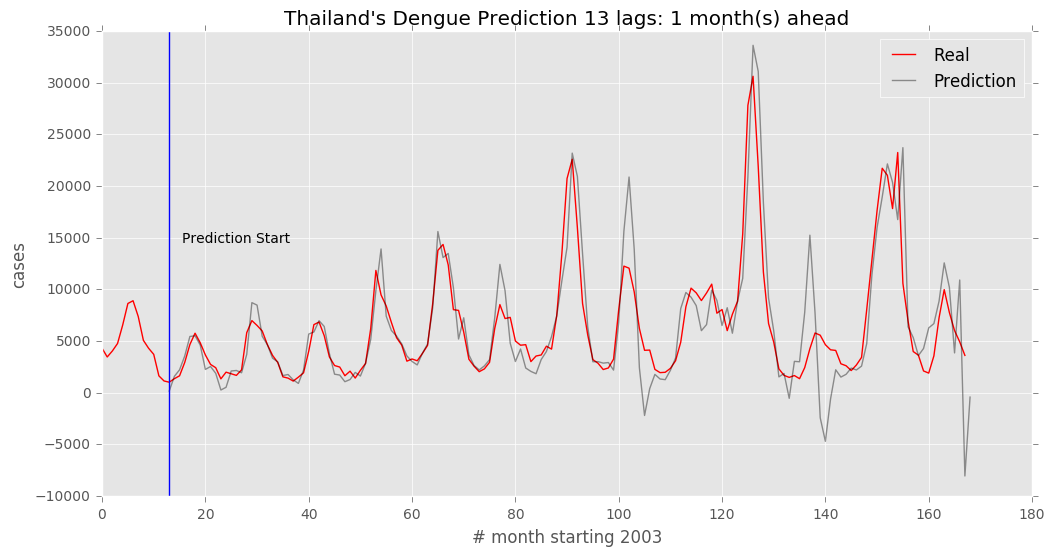

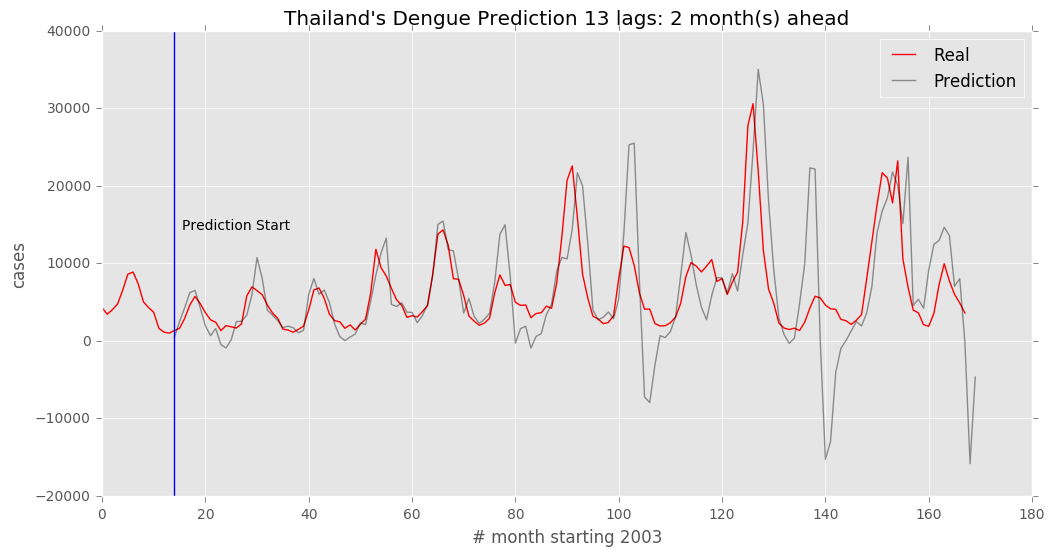

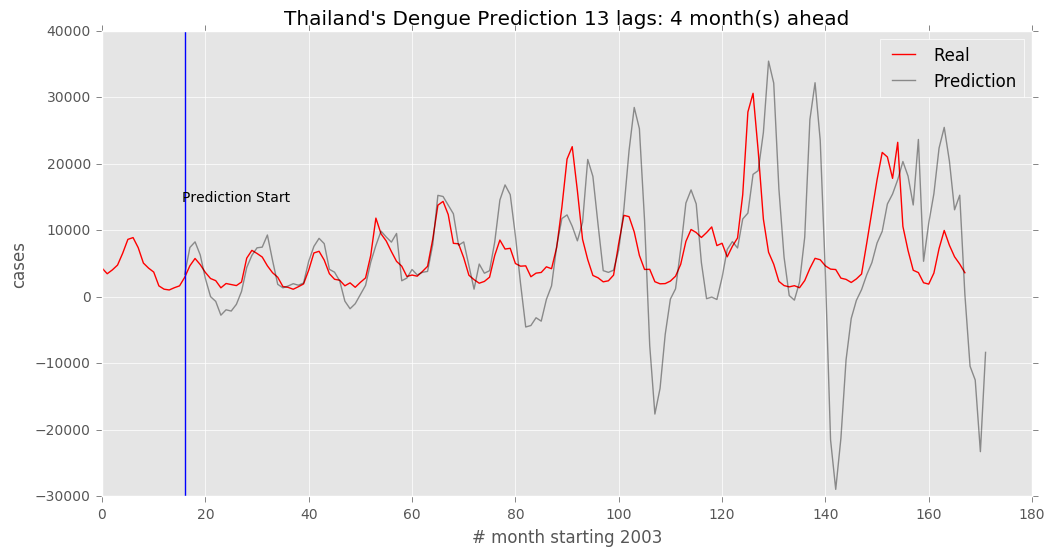

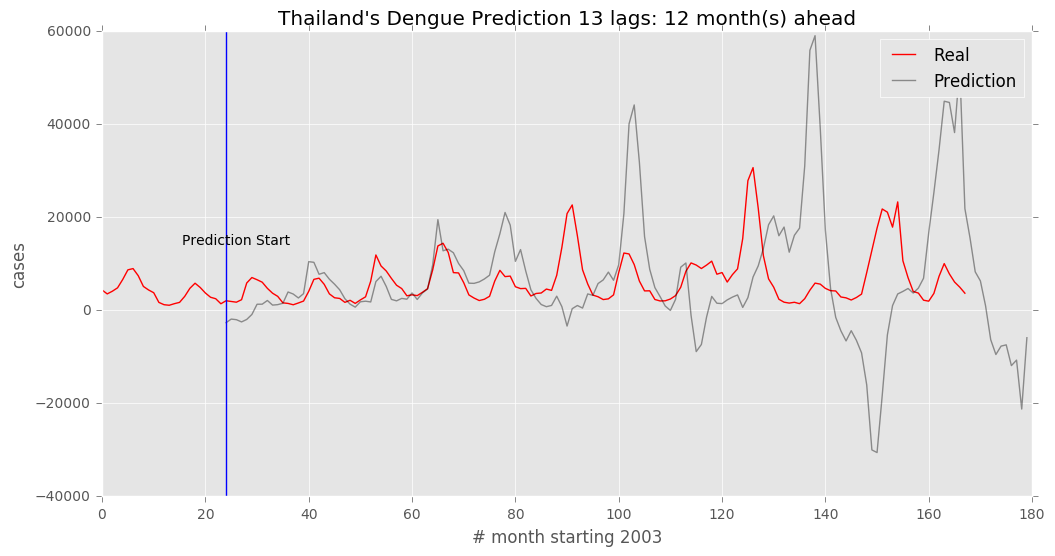

In [48]:
plot_prediction(13,train_test_mth,w.x,'Thailand')

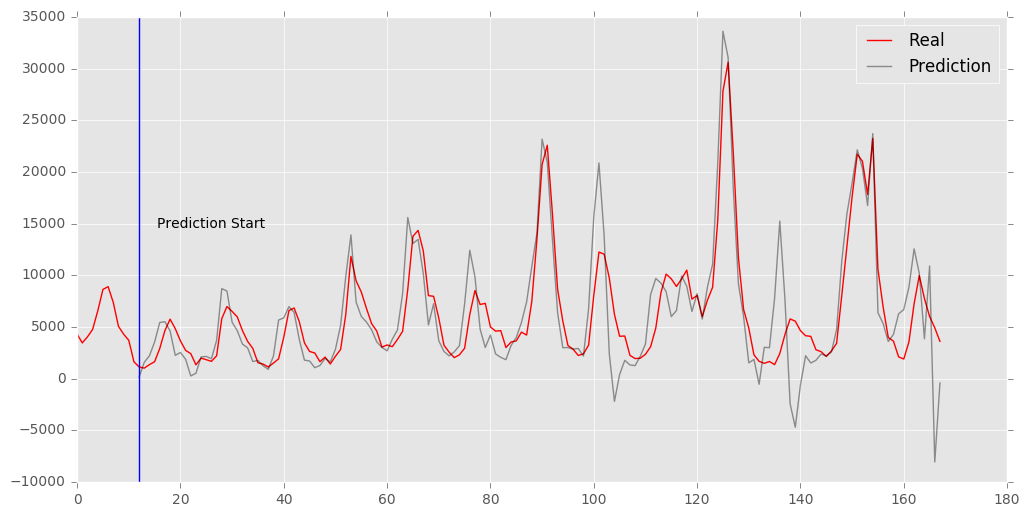

In [168]:
make_line(12,train_test,prediction_,"","","")